### VAE

This notebook is a simple implementation of a Variational Autoencoder (VAE) using PyTorch. The VAE is a generative model that learns to encode and decode data. The model is trained on Anime Face dataset.


In [32]:
import os
import time
import cv2
import tensorflow as tf
from keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Flatten,
    Reshape,
    Conv2DTranspose,
    LeakyReLU,
    BatchNormalization,
    Activation,
    Dropout,
    Rescaling,
)
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [34]:
print(tf.config.list_physical_devices("GPU"))
K.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [54]:
img_height, img_width = 256, 256
batch_size = 32

In [55]:
anime_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/anime_face/images",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode=None,
)

Found 63565 files belonging to 1 classes.


In [56]:
cartoon_train_ds = None

for i in range(5):
    cartoon_ds = tf.keras.preprocessing.image_dataset_from_directory(
        f"../data/cartoonset100k_jpg/{i}",
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode=None,
    )
    if cartoon_train_ds is None:
        cartoon_train_ds = cartoon_ds
    else:
        cartoon_train_ds = cartoon_train_ds.concatenate(cartoon_ds)

Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


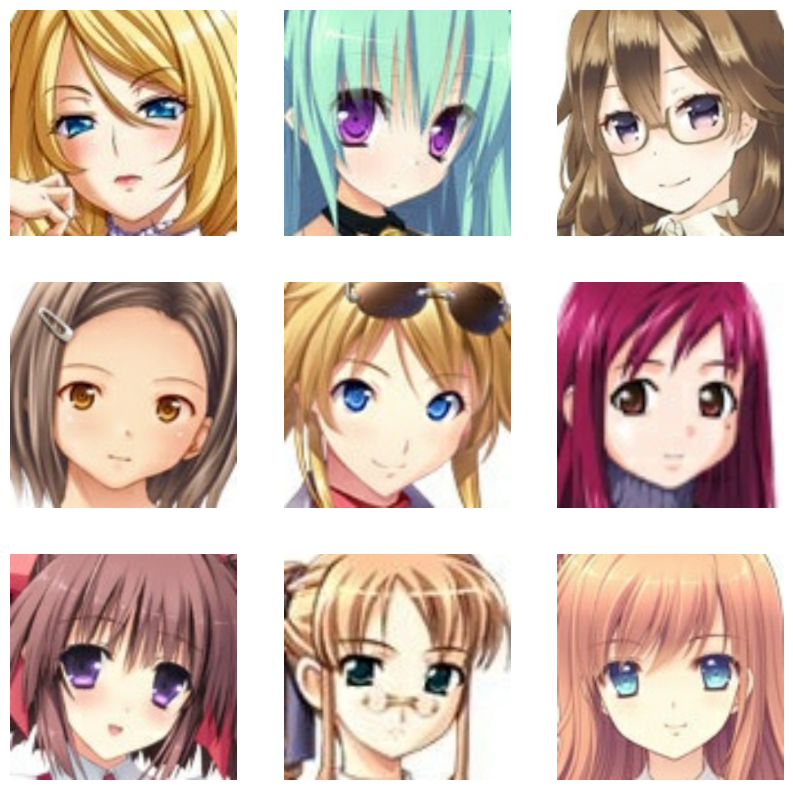

In [7]:
plt.figure(figsize=(10, 10))
for images in anime_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

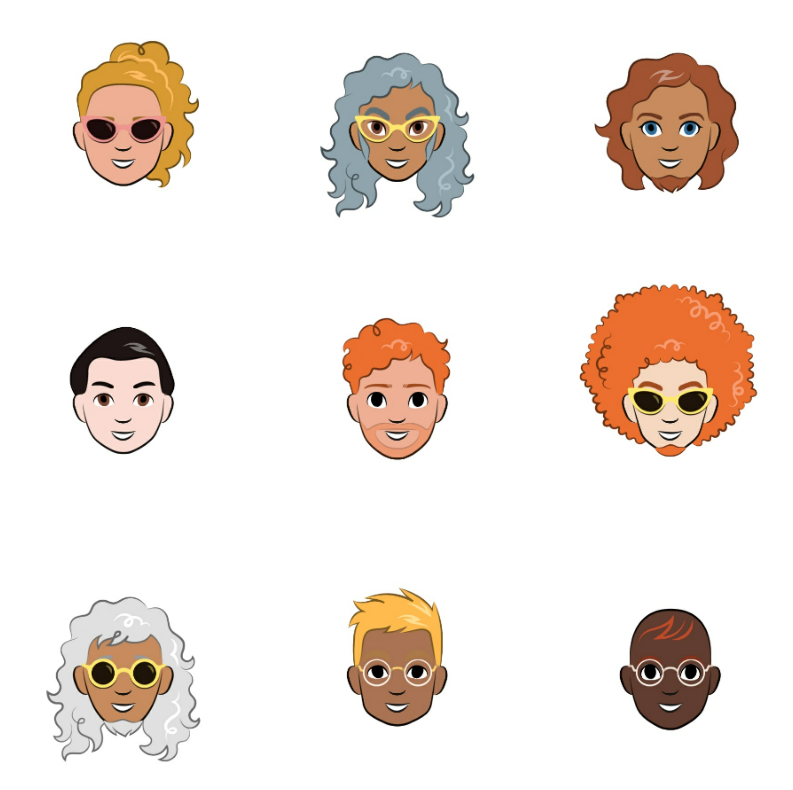

In [8]:
plt.figure(figsize=(10, 10))
for images in cartoon_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [36]:
normalization_layer = layers.Rescaling(scale=1.0 / 255)

In [8]:
anime_normalized_ds = anime_train_ds.map(lambda x: normalization_layer(x))
cartoon_normalized_ds = cartoon_train_ds.map(lambda x: normalization_layer(x))

In [9]:
image_batch = next(iter(cartoon_normalized_ds))
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.0, 1.0)

In [37]:
input_encoder = tuple(first_image.shape)
HIDDEN_DIM = 200
input_decoder = (HIDDEN_DIM,)

In [64]:
def encoder(input_encoder):
    inputs = Input(shape=input_encoder, name="input_layer")

    x = Conv2D(128, kernel_size=3, strides=2, padding="same", name="conv_1")(inputs)
    x = BatchNormalization(name="bn_1")(x)
    x = LeakyReLU(name="lrelu_1")(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same", name="conv_2")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = LeakyReLU(name="lrelu_2")(x)
    x = Dropout(0.2, name="dropout_1")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="conv_3")(x)
    x = BatchNormalization(name="bn_3")(x)
    x = LeakyReLU(name="lrelu_3")(x)
    x = Dropout(0.2, name="dropout_2")(x)

    x = Conv2D(32, kernel_size=3, strides=2, padding="same", name="conv_4")(x)
    x = BatchNormalization(name="bn_4")(x)
    x = LeakyReLU(name="lrelu_4")(x)
    x = Dropout(0.2, name="dropout_3")(x)

    flatten = Flatten()(x)

    mean = Dense(200, name="mean")(flatten)
    log_var = Dense(200, name="log_var")(flatten)

    model = Model(inputs, (mean, log_var), name="Encoder")

    return model

In [65]:
enc = encoder(input_encoder)
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 12  3584        ['input_layer[0][0]']            
                                8)                                                                
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 12  512         ['conv_1[0][0]']                 
                                8)                                                          

In [41]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0.0, stddev=1.0)
    return mean + K.exp(log_var / 2) * epsilon

def sampling(input_1, input_2):
    mean = Input(shape=input_1, name="input_layer1")
    log_var = Input(shape=input_2, name="input_layer2")
    out = layers.Lambda(sampling_model, name="encoder_output")([mean, log_var])
    enc_2 = tf.keras.Model([mean, log_var], out, name="Encoder_2")
    return enc_2

In [42]:
input_1 = (HIDDEN_DIM,)
input_2 = (HIDDEN_DIM,)
sample = sampling(input_1, input_2)

In [ ]:
sample.save("../models/sample_model_for_anime_faces.h5")

In [68]:
def decoder(input_decoder):

    inputs = Input(shape=input_decoder, name="input_layer")
    x = Dense(4096, name="dense_1")(inputs)
    x = Reshape((8, 8, 64), name="Reshape")(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", name="conv_transpose_1")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = LeakyReLU(name="lrelu_1")(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", name="conv_transpose_2")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = LeakyReLU(name="lrelu_2")(x)
    x = Dropout(0.2, name="dropout_1")(x)

    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", name="conv_transpose_3")(x)
    x = BatchNormalization(name="bn_3")(x)
    x = LeakyReLU(name="lrelu_3")(x)
    x = Dropout(0.2, name="dropout_2")(x)

    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", name="conv_transpose_4")(x)
    x = BatchNormalization(name="bn_4")(x)
    x = LeakyReLU(name="lrelu_4")(x)
    x = Dropout(0.2, name="dropout_3")(x)

    output = Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid", name="conv_transpose_5")(x)

    model = Model(inputs, output, name="Decoder")

    return model

In [69]:
dec = decoder(input_decoder)
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 32)        0         
                                                           

In [45]:
optimizer = Adam(learning_rate=0.0005)

In [46]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
    return 1000 * r_loss


def kl_loss(mean, log_var):
    kl_loss_ = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)
    return kl_loss_


def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return r_loss + kl_loss_

In [47]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:

        mean, log_var = enc(images, training=True)
        z = sample([mean, log_var])
        generated_images = dec(z, training=True)
        
        reconstruct_loss = mse_loss(images, generated_images)
        loss = vae_loss(images, generated_images, mean, log_var)

    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)

    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    
    return reconstruct_loss, loss

In [48]:
def save_generated_images(model, epoch, test_input, name):
    mean, var = enc(test_input, training=False)
    latent = sample([mean, var])
    predictions = dec(latent, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)

        plt.imshow(pred)
        plt.axis("off")

    plt.savefig(f"../images/VAE/{name}/image_at_epoch_{epoch}.png")
    plt.show()

In [49]:
def train(dataset, epochs, name):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        reconstruct_losses = []
        
        for image_batch in dataset:
            reconstruct_loss, loss = train_step(image_batch)
            
            loss = np.mean(loss.numpy())
            reconstruct_loss = np.mean(reconstruct_loss.numpy())
            
            losses.append(loss)
            reconstruct_losses.append(reconstruct_loss)

        seed = image_batch[:25]
        save_generated_images([enc, sample, dec], epoch + 1, seed, name)

        print("Epoch: ", epoch + 1, " Loss: ", losses[-1], " Reconstruct Loss: ", reconstruct_losses[-1], " Time: ", time.time() - start)

    save_generated_images([enc, sample, dec], epochs, seed, name)
    
    enc.save_weights(f"../models/{name}/enc.h5")
    dec.save_weights(f"../models/{name}/dec.h5")

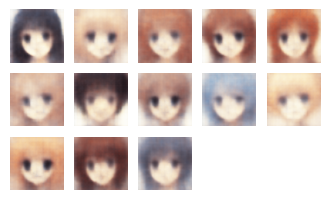

Epoch:  1  Loss:  45.113102  Reconstruct Loss:  37.526035  Time:  375.5771789550781


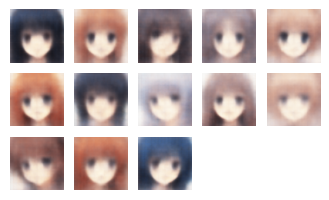

Epoch:  2  Loss:  42.10288  Reconstruct Loss:  35.256493  Time:  388.4650020599365


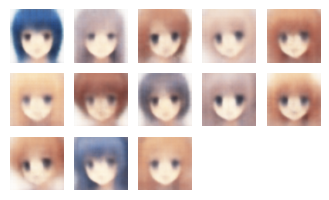

Epoch:  3  Loss:  40.888332  Reconstruct Loss:  33.999104  Time:  391.7428877353668


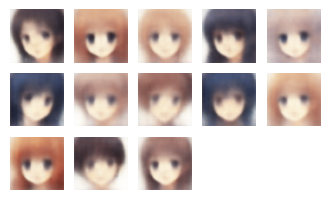

Epoch:  4  Loss:  42.977787  Reconstruct Loss:  36.14412  Time:  383.18104577064514


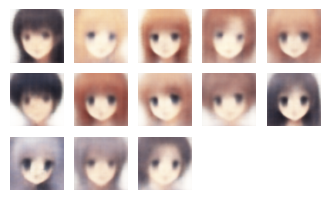

Epoch:  5  Loss:  43.67771  Reconstruct Loss:  36.325558  Time:  369.0791726112366


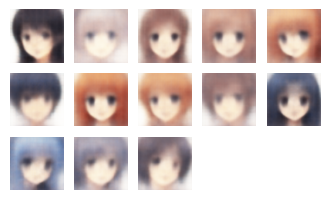

In [26]:
train(anime_normalized_ds, 5, "anime")

In [50]:
enc.load_weights("../models/anime/enc.h5")
dec.load_weights("../models/anime/dec.h5")

1/1 [==============================] - 0s 112ms/step


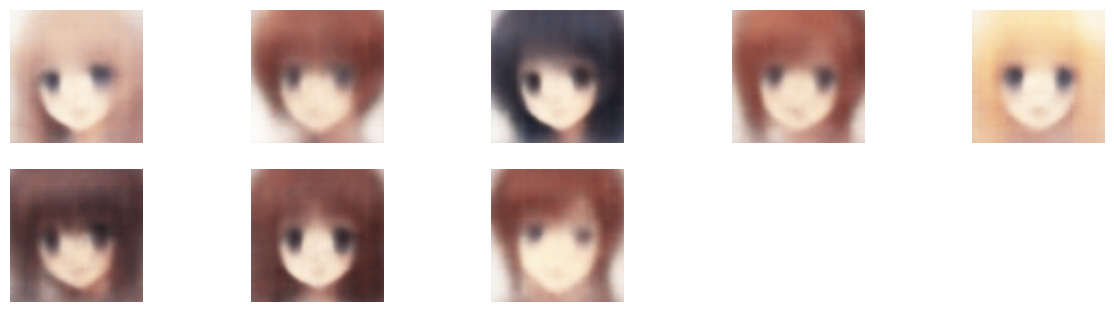

In [57]:
figsize = 15

x = np.random.normal(size=(10, 200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(figsize, 10))

for i in range(8):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.axis("off")
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

2/2 [==============================] - 0s 36ms/step


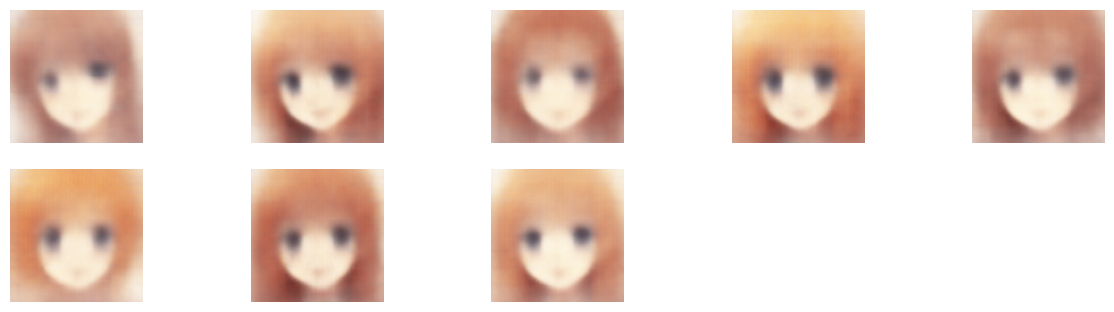

In [58]:
figsize = 15
x = np.random.exponential(scale=0.7, size=(50, 200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(figsize, 10))

for i in range(8):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.axis("off")
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

In [ ]:
enc = encoder(input_encoder)
sample = sampling(input_1, input_2)
sample.save("../models/sample_model_for_cartoon_faces.h5")
dec = decoder(input_decoder)

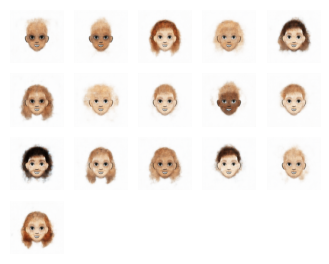

Epoch:  1  Loss:  22.641958  Reconstruct Loss:  17.313942  Time:  300.17361307144165


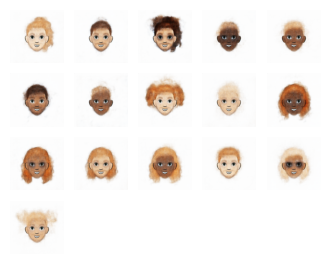

Epoch:  2  Loss:  20.999107  Reconstruct Loss:  16.009174  Time:  306.5335018634796


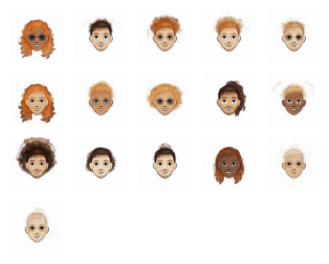

Epoch:  3  Loss:  20.68335  Reconstruct Loss:  15.09233  Time:  310.165322303772


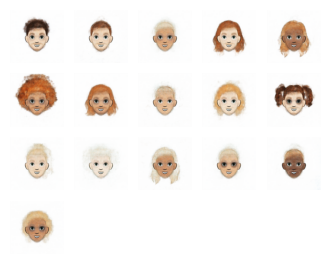

Epoch:  4  Loss:  17.218472  Reconstruct Loss:  11.97661  Time:  320.37937593460083


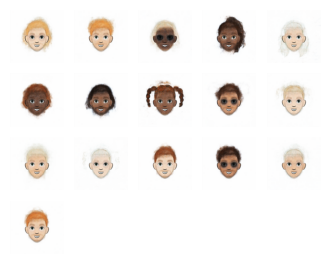

Epoch:  5  Loss:  16.53772  Reconstruct Loss:  11.898354  Time:  327.02315759658813


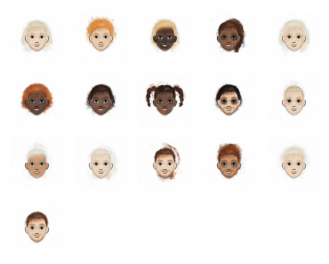

In [24]:
train(cartoon_normalized_ds, 5, "cartoon")

In [59]:
enc.load_weights("../models/cartoon/enc.h5")
dec.load_weights("../models/cartoon/dec.h5")

1/1 [==============================] - 0s 18ms/step


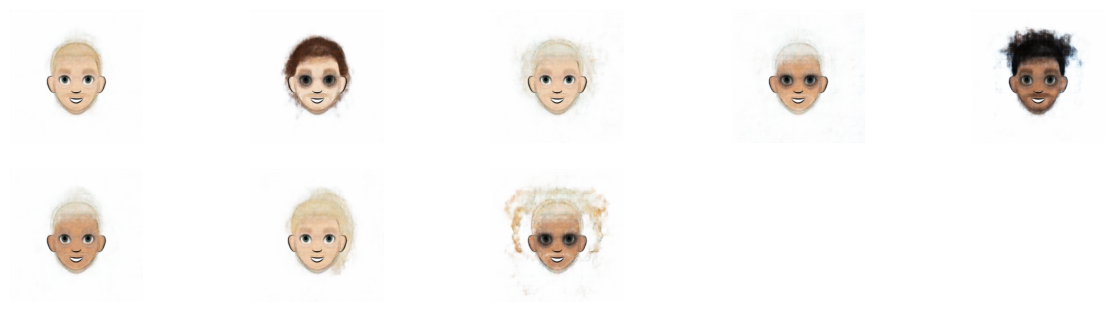

In [60]:
figsize = 15

x = np.random.normal(size=(10, 200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(figsize, 10))

for i in range(8):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.axis("off")
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

2/2 [==============================] - 0s 35ms/step


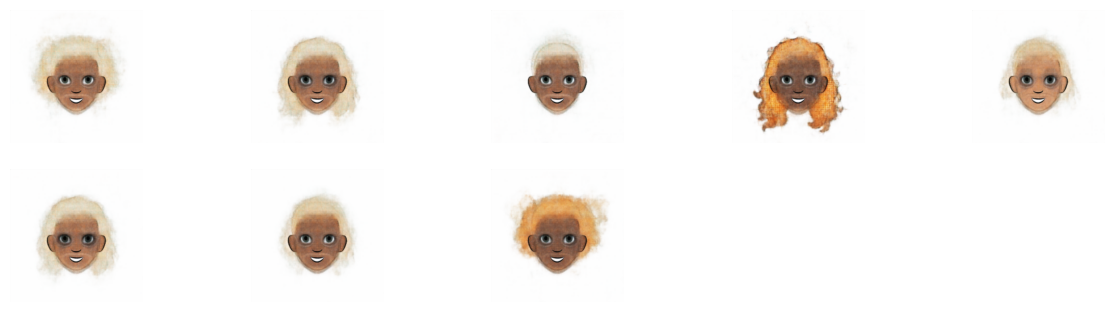

In [61]:
figsize = 15
x = np.random.exponential(scale=0.7, size=(50, 200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(figsize, 10))

for i in range(8):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.axis("off")
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)